# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1ec5FVFzEv9wxh8iHf1lqGUhq-LXMKBDG?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


### 0. Helper Functions ###

In [3]:
###############################################################################
# Data Loading
def get_data_loader(data_dir, batch_size, image_size=(224, 224)):

    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize(image_size),  
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load the dataset
    dataset = ImageFolder(root=data_dir, transform=transform)
    classes = dataset.classes
    
    # Dictionary to hold indices for each class
    class_indices = {cls: [] for cls in classes}
    
    # Populate the class_indices dictionary
    for idx, (image, label) in enumerate(dataset):
        class_indices[classes[label]].append(idx)
    
    # Lists to hold indices for train, validation, and test sets
    train_indices = []
    val_indices = []
    test_indices = []
    
    for cls, indices in class_indices.items():
        np.random.seed(1000)  
        np.random.shuffle(indices)
        
        train_split = int(0.7 * len(indices))
        val_split = int(0.15 * len(indices))
        
        train_indices.extend(indices[:train_split])
        val_indices.extend(indices[train_split:train_split + val_split])
        test_indices.extend(indices[train_split + val_split:])
    
    # Create data loaders
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)
    
    return train_loader, val_loader, test_loader, classes, train_indices, val_indices, test_indices


def check_for_overlaps(train_indices, val_indices, test_indices):
    # Convert indices to sets
    train_indices_set = set(train_indices)
    val_indices_set = set(val_indices)
    test_indices_set = set(test_indices)

    # Check for overlaps
    train_val_overlap = train_indices_set.intersection(val_indices_set)
    train_test_overlap = train_indices_set.intersection(test_indices_set)
    val_test_overlap = val_indices_set.intersection(test_indices_set)

    # Print the results
    print(f"Train/Validation Overlap: {len(train_val_overlap)} indices")
    print(f"Train/Test Overlap: {len(train_test_overlap)} indices")
    print(f"Validation/Test Overlap: {len(val_test_overlap)} indices")

    if not train_val_overlap and not train_test_overlap and not val_test_overlap:
        print("No overlaps found between train, validation, and test sets.")
    else:
        print("Overlaps detected. Please check the data splitting logic.")

###############################################################################
# Training
def evaluate(net, loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    total_loss = 0.0
    total_err = 0.0
    total_samples = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)
    err = total_err / total_samples
    loss = total_loss / len(loader)
    return err, loss

def get_model_name(name, batch_size, learning_rate, epoch):
    
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


###############################################################################
# Training Curve
def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

### 1.1 Load Data ###

In [4]:
data_dir = './Lab3_Gestures_Summer' 
batch_size = 32  
# Get data loaders and indices
train_loader, val_loader, test_loader, classes, train_indices, val_indices, test_indices = get_data_loader(data_dir, batch_size=32, image_size=224)
# I split the data using get_data_loader in part 0's helper functions. 
# Then I decided to use 70% of the total data for the training set, and 15% for both validation set and testing set.
# Since every class [A to I] had around 250~ images I wanted to make sure every set had photos from each.
# In order to do this I took the first 70% of photos from each class for training set then the next 15% from each and so on.
# I wanted to verify the split and made sure there were no photos overlapping the data sets so I did so in 1.2
# Additionally I wanted to see the photos so I did so in 1.3

print(classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']


### 1.2 Verifying Split ###

In [5]:
# Verify the split sizes
total_examples = len(train_loader.sampler) + len(val_loader.sampler) + len(test_loader.sampler)
train_size = len(train_loader.sampler)
val_size = len(val_loader.sampler)
test_size = len(test_loader.sampler)

train_proportion = train_size / total_examples
val_proportion = val_size / total_examples 
test_proportion = test_size / total_examples

print(f"Total examples: {total_examples}")
print(f"Train examples: {train_size} ({train_proportion:.2%})")
print(f"Validation examples: {val_size} ({val_proportion:.2%})")
print(f"Test examples: {test_size} ({test_proportion:.2%})")

# Check for overlaps
check_for_overlaps(train_indices, val_indices, test_indices)

Total examples: 2219
Train examples: 1548 (69.76%)
Validation examples: 330 (14.87%)
Test examples: 341 (15.37%)
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.


### 1.3 Visualize Data ###

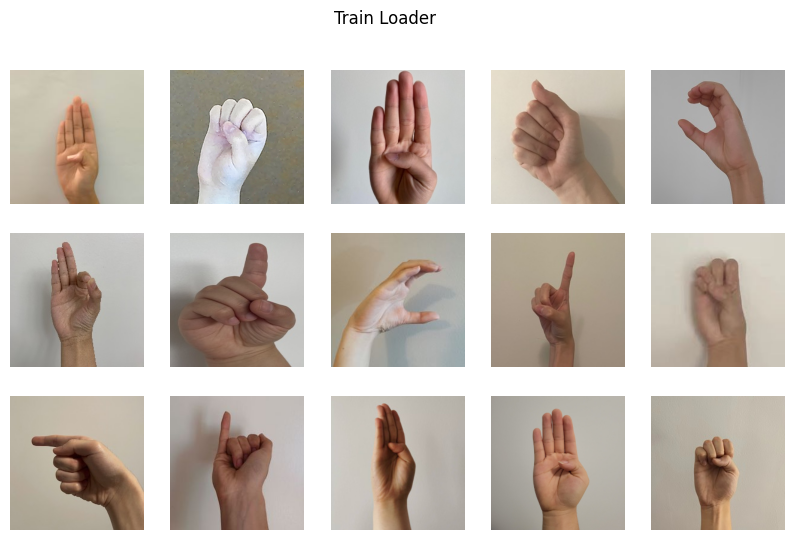

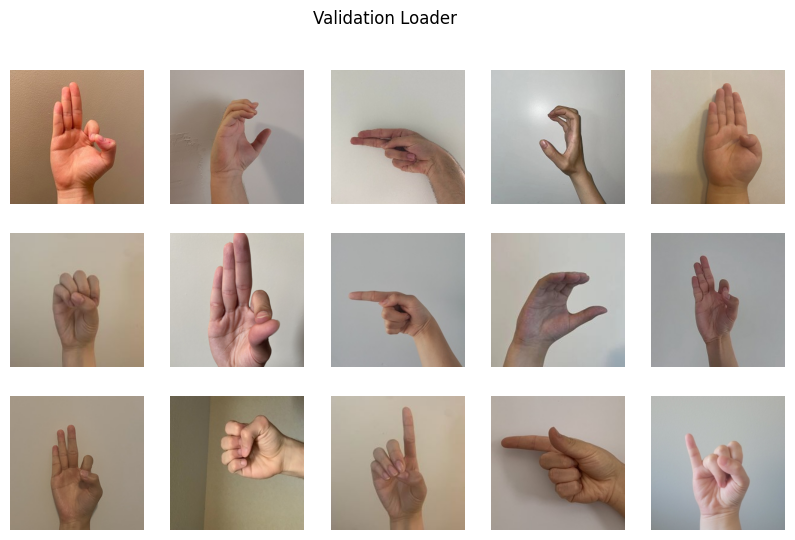

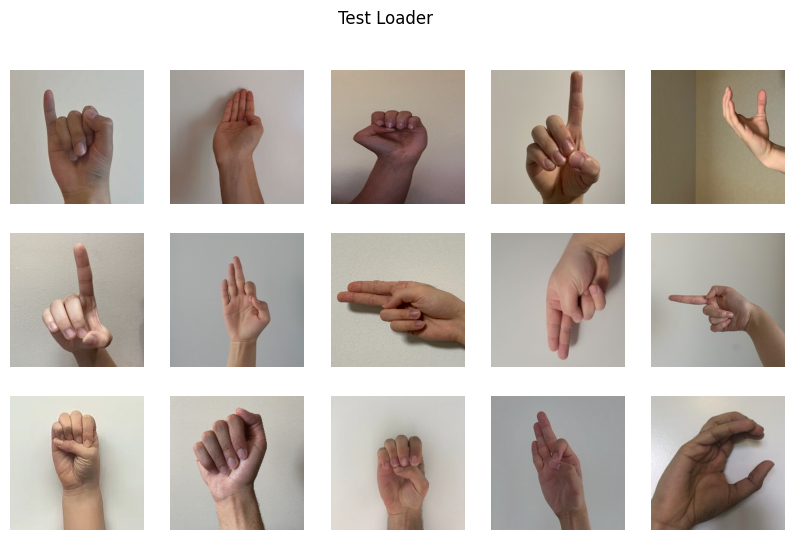

In [62]:
import matplotlib.pyplot as plt

# Taken from Lab 2
def visualize_data_loader(data_loader, title, num_images=15):
    k = 0
    plt.figure(figsize=(10, 6))
    for images, labels in data_loader:
        for i in range(images.size(0)):  
            if k >= num_images:
                break
            image = images[i]
            img = np.transpose(image.numpy(), [1, 2, 0])
            img = img / 2 + 0.5
            plt.subplot(3, 5, k+1)
            plt.axis('off')
            plt.imshow(img)
            k += 1
        if k >= num_images:
            break
    plt.suptitle(title)
    plt.show()

visualize_data_loader(train_loader, title="Train Loader")
visualize_data_loader(val_loader, title="Validation Loader")
visualize_data_loader(test_loader, title="Test Loader")

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [6]:
# My CNN architecture consists of 3 convolutional layers and 2 fully connected layers.
# Then I connected my first two convolutional layers with a max pooling layer. 
# This reduces the spatial dimensions of the feature maps by half.
# Then the intermediate result is flattened as input to the two fully connected linear layers to produce the classification result. 
# ReLU Activation is used after each convolutional layer and the first fully connected layer. 
# ReLu helps introduce non-linearity to the model, allowing it to learn complex patterns in the data.
# The hidden units (or channels) in the convolutional layers follow a progressive increase: 
# 32, 64, and 128. This allows the model to capture increasingly complex features as the data moves through the layers.
# The fully connected layers use 512 hidden units in the first layer

import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class ASLCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLCNN, self).__init__()
        self.name = "asl"
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28 ) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Using device: cuda


In [7]:
num_classes = 9
asl_net = ASLCNN(num_classes)

### 2a.i Total Number of Parameters ###

In [384]:
# Checking the total number of parameters for my self
total_asl = 0

# total number of parameters for asl
for param in asl_net.parameters():
    total_asl += param.numel()
print(total_asl)

# 51478601 paramaters for small_net


51478601


### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [12]:
# I chose CrossEntropyLoss as it handles multi-class classification which is perfect for our model
# CrossEntropyLoss is specifically designed for classification tasks simliar to ASL which each hand belongs to one of several classes. 
# I decided to use SGD as my optimizer as it is straightforward and commonly used optimizer across the industry 
# I decided against Adam as SGD can better generalize than Adam as has fixed steps.

def train_net(net, data_dir, batch_size=32, learning_rate=0.01, num_epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    net.to(device)  # Move model to GPU/CPU
    torch.manual_seed(1000)
    train_loader, val_loader, test_loader, classes, train_indices, val_indices, test_indices = get_data_loader(
        data_dir, batch_size, image_size=(224, 224))
    
    criterion = nn.CrossEntropyLoss().to(device)  # Move criterion to GPU
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        net.train()  
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_epoch += labels.size(0)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [386]:
data_dir = './Lab3_Gestures_Summer'  
num_classes = 9  
asl_net = ASLCNN(num_classes)
train_net(asl_net, data_dir, batch_size=32, learning_rate=0.01, num_epochs=5)

Using device: cuda
Epoch 1: Train err: 0.7564599483204134, Train loss: 2.0432266799771055 |Validation err: 0.5666666666666667, Validation loss: 1.5622534643520007
Epoch 2: Train err: 0.4748062015503876, Train loss: 1.3278015316749106 |Validation err: 0.4121212121212121, Validation loss: 1.1201492006128484
Epoch 3: Train err: 0.3475452196382429, Train loss: 0.9780712772388848 |Validation err: 0.3212121212121212, Validation loss: 0.9470461932095614
Epoch 4: Train err: 0.28811369509043927, Train loss: 0.8456700973364771 |Validation err: 0.32727272727272727, Validation loss: 0.9078611406412992
Epoch 5: Train err: 0.2739018087855297, Train loss: 0.7290075670699684 |Validation err: 0.27575757575757576, Validation loss: 0.7426097393035889
Finished Training
Total time elapsed: 26.07 seconds


### 2b.i Plot ###

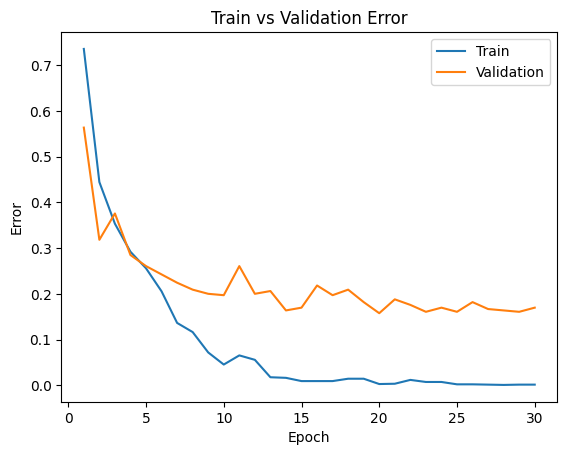

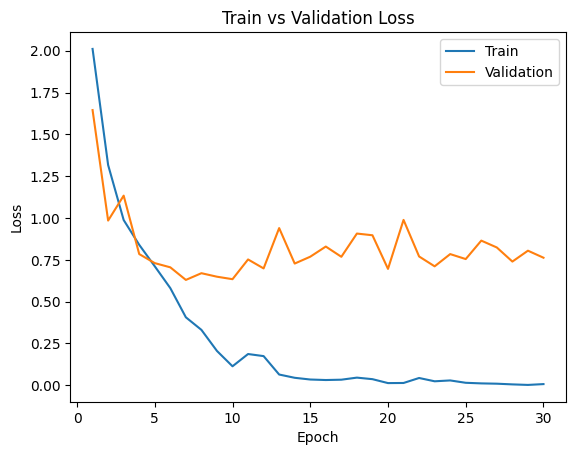

In [48]:
# plot for myself
asl_net_model_path= get_model_name("asl", batch_size=32, learning_rate=0.01, epoch=29)
plot_training_curve(asl_net_model_path)

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

### 2c.i Construct Small Dataset ###

In [8]:
# Function to create a small dataset
def create_small_dataset(data_dir, num_samples=10, image_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = ImageFolder(root=data_dir, transform=transform)
    
    # Randomly select a few samples to create a small dataset
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    small_dataset = Subset(dataset, indices)
    
    return small_dataset

### 2c.ii Train Small Dataset ###

In [9]:
# Function to train on a small dataset
def train_on_small_dataset(net, small_dataset, batch_size=10, learning_rate=0.01, num_epochs=200):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)  # Move model to GPU
    torch.manual_seed(1000)
    
    small_loader = DataLoader(small_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    
    criterion = nn.CrossEntropyLoss().to(device)  # Move criterion to GPU
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    train_losses = []
    train_errors = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        net.train() 
        for i, data in enumerate(small_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

            # Check label values
            assert labels.max().item() < num_classes, f"Invalid label value found: {labels.max().item()}"

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_epoch += labels.size(0)
        
        train_err = float(total_train_err) / total_epoch
        train_loss = float(total_train_loss) / (i+1)
        
        train_losses.append(train_loss)
        train_errors.append(train_err)
        
        print(f"Epoch {epoch+1}: Train err: {train_err}, Train loss: {train_loss}")
        
        # Save checkpoint
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
        
        if train_err == 0.0:
            print("Model has successfully memorized the small dataset.")
            break

    np.savetxt(f"{model_path}_train_err.csv", np.array(train_errors))
    np.savetxt(f"{model_path}_train_loss.csv", np.array(train_losses))


In [389]:
data_dir = './Lab3_Gestures_Summer'  
num_samples = 10  
num_classes = 9  

small_asl_dataset = create_small_dataset(data_dir, num_samples)
model = ASLCNN(num_classes)

# Train on the small dataset
train_on_small_dataset(model, small_asl_dataset, batch_size=10, learning_rate=0.01, num_epochs=200)

Epoch 1: Train err: 1.0, Train loss: 2.2045416831970215
Epoch 2: Train err: 0.7, Train loss: 2.189177989959717
Epoch 3: Train err: 0.8, Train loss: 2.1676712036132812
Epoch 4: Train err: 0.8, Train loss: 2.141944408416748
Epoch 5: Train err: 0.8, Train loss: 2.1094839572906494
Epoch 6: Train err: 0.8, Train loss: 2.0697007179260254
Epoch 7: Train err: 0.7, Train loss: 2.022287607192993
Epoch 8: Train err: 0.6, Train loss: 1.968303918838501
Epoch 9: Train err: 0.5, Train loss: 1.9132484197616577
Epoch 10: Train err: 0.4, Train loss: 1.8657909631729126
Epoch 11: Train err: 0.4, Train loss: 1.8311898708343506
Epoch 12: Train err: 0.4, Train loss: 1.7958157062530518
Epoch 13: Train err: 0.4, Train loss: 1.7312908172607422
Epoch 14: Train err: 0.4, Train loss: 1.6324666738510132
Epoch 15: Train err: 0.4, Train loss: 1.5251041650772095
Epoch 16: Train err: 0.1, Train loss: 1.424250602722168
Epoch 17: Train err: 0.0, Train loss: 1.275150179862976
Model has successfully memorized the small dat

In [10]:
# plot the training curves for small_net
def plot_training_curve_small(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    n = len(train_err) # number of epochs

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title("Train Error")
    plt.plot(range(1, n+1), train_err, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title("Train Loss")
    plt.plot(range(1, n+1), train_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

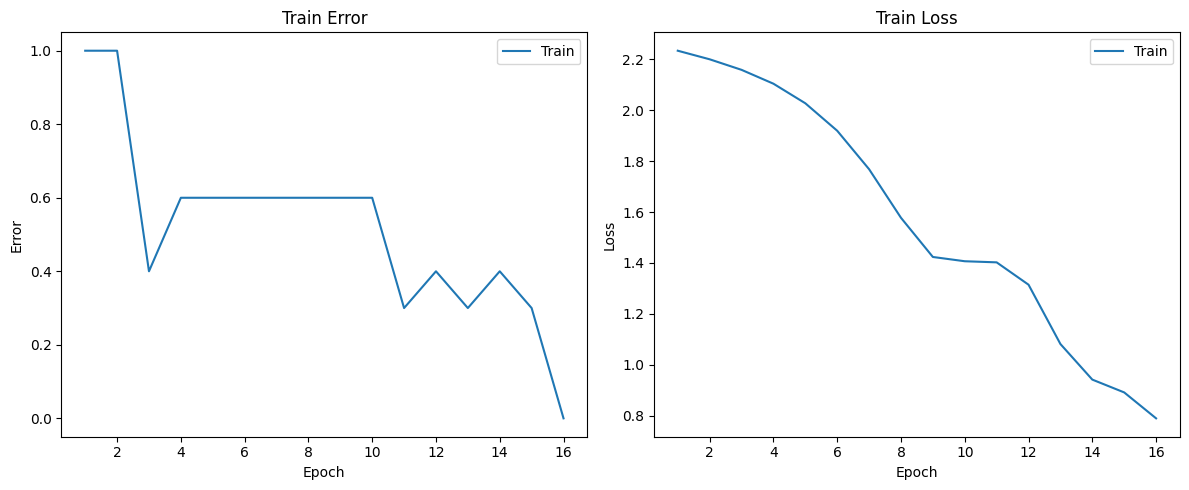

In [266]:
small_asl_net_model_path= get_model_name("asl", batch_size=10, learning_rate=0.01, epoch=15)
plot_training_curve_small(small_asl_net_model_path)

**We can notice that training error is zero => 100% training accuracy**

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

**(1) Number of Layers/Filter Size (Model Architecture Parameter):**

- **Number of Layers/Filter Size:** The number of layers and filter size will impact the model's ability to capture complex features. More layers can potentially capture more complex patterns but also make the model more prone to overfitting and harder to train.
- **Normalization/Regularization:** We can also try to add batch normalization or dropout to help overfitting by reducing how much the model can "learn" the training data and to ensure the model is learning everything equally.

I can experiment with different network depths and filter sizes. For example, I can use a more simple architecture to begin with and add more layers or adjust the filter size.

**(2) Learning Rate:**

Learning rate is the second parameter that I believe is worth tuning. This is because the learning controls how quickly or slowly we step toward a minimum of our loss function. A learning rate that is too high or one that is too low may cause suboptimal results and add unncessary training time.

**(3) Batch Size:**

Batch size is the third parameter I believe is worth tuning. Batch size is important as it tells us how many samples will be used in one iteration. Larger batch sizes may provide more accurate estimates of the gradient as it looks at more data before making a parameter update. A model using smaller batch sizes will update its parameters more often but will tend to overfit/lead to noisier updates. I can try different batch sizes to balance between training stability and computational efficiency. Common batch sizes are powers of 2, like 32, 64, 128, etc.



### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

### 3b.i Decreased Learning Rate ###

In [13]:
data_dir = './Lab3_Gestures_Summer'  
num_classes = 9  
asl_net = ASLCNN(num_classes)
train_net(asl_net, data_dir, batch_size=32, learning_rate=0.001, num_epochs=30)

Using device: cuda
Epoch 1: Train err: 0.8617571059431525, Train loss: 2.192995475263012 |Validation err: 0.796969696969697, Validation loss: 2.182155804200606
Epoch 2: Train err: 0.7655038759689923, Train loss: 2.1668258978396047 |Validation err: 0.6363636363636364, Validation loss: 2.1371892148798164
Epoch 3: Train err: 0.5781653746770026, Train loss: 2.028695203820053 |Validation err: 0.5484848484848485, Validation loss: 1.847569227218628
Epoch 4: Train err: 0.4877260981912145, Train loss: 1.5181363018191592 |Validation err: 0.43333333333333335, Validation loss: 1.4236474253914573
Epoch 5: Train err: 0.39728682170542634, Train loss: 1.1912097188891198 |Validation err: 0.396969696969697, Validation loss: 1.1886596408757297
Epoch 6: Train err: 0.3669250645994832, Train loss: 1.1046467119333696 |Validation err: 0.3515151515151515, Validation loss: 1.0743255669420415
Epoch 7: Train err: 0.31976744186046513, Train loss: 0.9514309386817776 |Validation err: 0.3303030303030303, Validation l

LEARNING RATE = 0.001


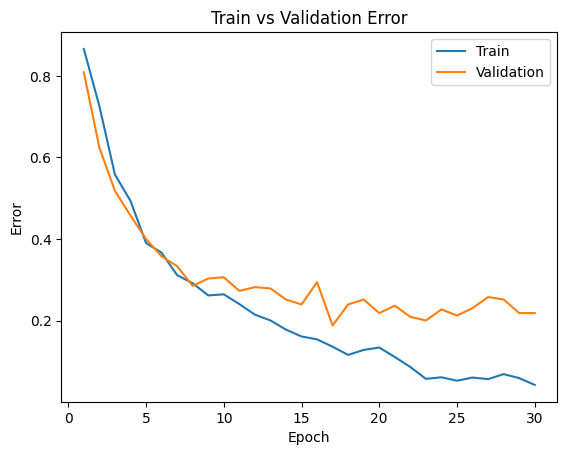

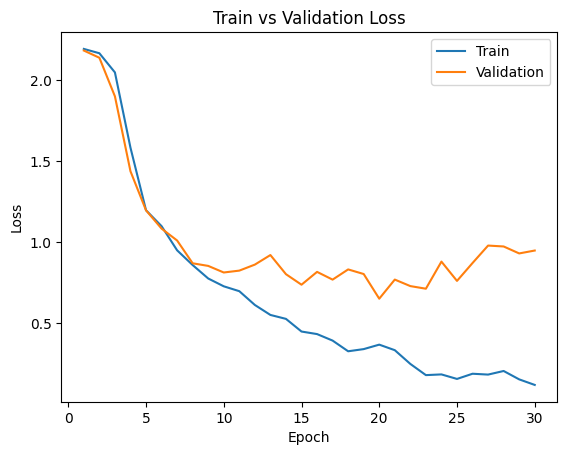

In [32]:
# plot the training curve for asl small learning rate
asl_net_model_path= get_model_name("asl", batch_size=32, learning_rate=0.001, epoch=29)
print('LEARNING RATE = 0.001')
plot_training_curve(asl_net_model_path)

### 3b.ii Increased Batch Size ###

In [14]:
# Get data loaders and indices
train_loader, val_loader, test_loader, classes, train_indices, val_indices, test_indices = get_data_loader(data_dir, batch_size=64, image_size=224)

data_dir = './Lab3_Gestures_Summer'  
num_classes = 9  # 
asl_net = ASLCNN(num_classes)
train_net(asl_net, data_dir, batch_size=64, learning_rate=0.01, num_epochs=30)

Using device: cuda
Epoch 1: Train err: 0.8223514211886305, Train loss: 2.1833082580566407 |Validation err: 0.706060606060606, Validation loss: 2.133535941441854
Epoch 2: Train err: 0.6789405684754521, Train loss: 1.8515998649597167 |Validation err: 0.5181818181818182, Validation loss: 1.5748709837595622
Epoch 3: Train err: 0.47351421188630494, Train loss: 1.3172392559051513 |Validation err: 0.5424242424242425, Validation loss: 1.4329808155695598
Epoch 4: Train err: 0.35400516795865633, Train loss: 1.0337764477729798 |Validation err: 0.3878787878787879, Validation loss: 1.02883513768514
Epoch 5: Train err: 0.3165374677002584, Train loss: 0.8768063187599182 |Validation err: 0.396969696969697, Validation loss: 1.0950322051843007
Epoch 6: Train err: 0.3107235142118863, Train loss: 0.870631320476532 |Validation err: 0.30606060606060603, Validation loss: 0.8942588269710541
Epoch 7: Train err: 0.2713178294573643, Train loss: 0.741181823015213 |Validation err: 0.3151515151515151, Validation lo

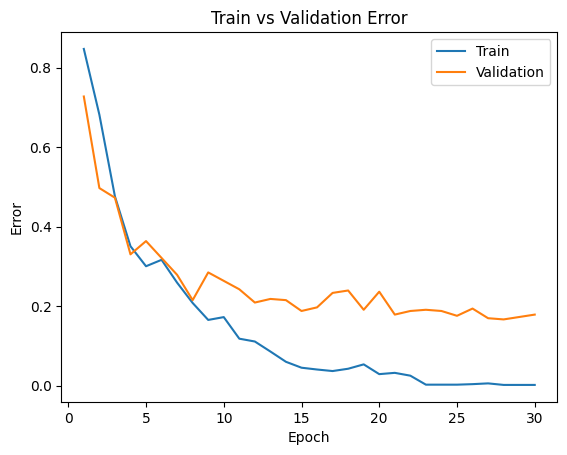

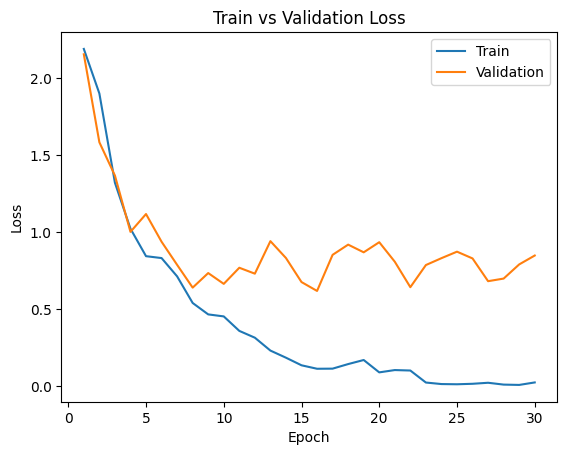

In [182]:
# plot the training curves for asl with increased batch size
asl_net_model_path= get_model_name("asl", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(asl_net_model_path)

### 3b.iii Adjusted Filter Size (Decreased) ###

In [19]:
class ASLCNN_small(nn.Module):
    def __init__(self, num_classes):
        super(ASLCNN_small, self).__init__()
        self.name = "asl_small"
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x)))  
        x = x.view(-1, 64 * 28 * 28)  # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
data_dir = './Lab3_Gestures_Summer'  
num_classes = 9  
asl_small_net = ASLCNN_small(num_classes)

total_asl = 0

# total number of parameters for asl
for param in asl_small_net.parameters():
    total_asl += param.numel()
print(total_asl)

# 51478601 paramaters for asl
# 25718825 < 51478601
# lower filter size gave us less parameters

25718825


In [21]:
train_net(asl_small_net, data_dir, batch_size=32, learning_rate=0.01, num_epochs=30)

Using device: cuda
Epoch 1: Train err: 0.8443152454780362, Train loss: 2.183976869193875 |Validation err: 0.6121212121212121, Validation loss: 2.0808709968220103
Epoch 2: Train err: 0.5645994832041343, Train loss: 1.640432902744838 |Validation err: 0.37575757575757573, Validation loss: 1.192476050420241
Epoch 3: Train err: 0.4043927648578811, Train loss: 1.131699150922347 |Validation err: 0.3878787878787879, Validation loss: 1.1791935834017666
Epoch 4: Train err: 0.3359173126614987, Train loss: 0.9818204154773634 |Validation err: 0.34545454545454546, Validation loss: 0.9843497222120111
Epoch 5: Train err: 0.2990956072351421, Train loss: 0.8335547568846722 |Validation err: 0.22727272727272727, Validation loss: 0.7618029822002758
Epoch 6: Train err: 0.25516795865633074, Train loss: 0.7014125354435979 |Validation err: 0.22121212121212122, Validation loss: 0.7749552645466544
Epoch 7: Train err: 0.2144702842377261, Train loss: 0.5931277360234942 |Validation err: 0.24848484848484848, Validat

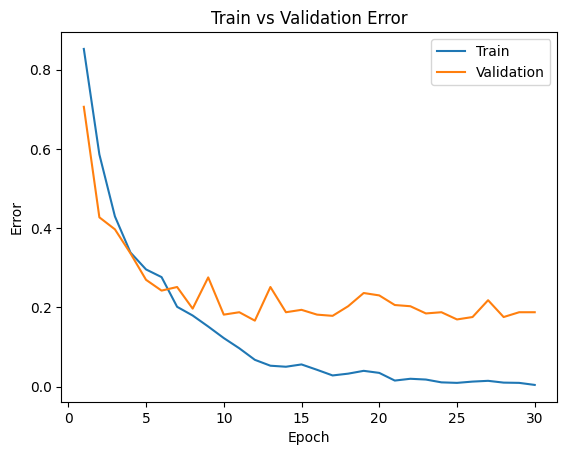

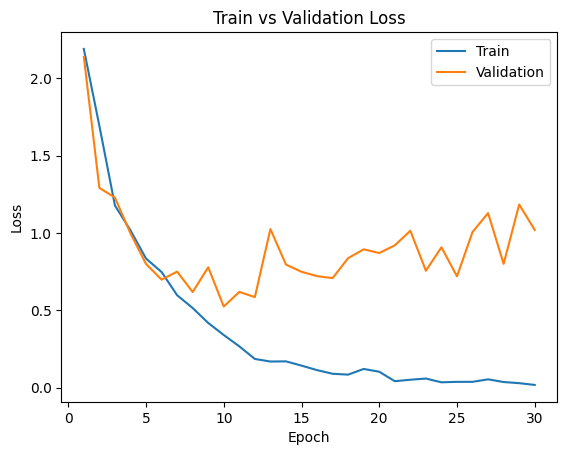

In [84]:
# plot the training curves for decreased filter size
asl_net_model_path= get_model_name("asl_small", batch_size=32, learning_rate=0.01, epoch=29)
plot_training_curve(asl_net_model_path)

### 3b.iv Added extra convolutional layer/increased batch size/lowered learning rate  ###

In [22]:
# Check if CUDA is available and set the device
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class ASLCNN_final(nn.Module):
    def __init__(self, num_classes):
        super(ASLCNN_final, self).__init__()
        super(ASLCNN_final, self).__init__()
        self.name = "asl_final"
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)  
        self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)  
        self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=2)  
        self.conv4 = nn.Conv2d(64, 128, 5, stride=1, padding=2)  
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(128 * 14 * 14, 512)  
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        x = self.pool(F.relu(self.conv4(x)))  
        x = x.view(-1, 128 * 14 * 14)  # Flatten
        x = self.dropout(x)
        x = F.relu((self.fc1(x)))
        x = self.fc2(x)
        return x
 

Using device: cuda


In [23]:
# Get data loaders and indices
train_loader, val_loader, test_loader, classes, train_indices, val_indices, test_indices = get_data_loader(data_dir, batch_size=64, image_size=224)

In [24]:
data_dir = './Lab3_Gestures_Summer'  # Update this with the path to your dataset
num_classes = 9  # Adjust based on the number of asl classes
asl_net = ASLCNN_final(num_classes)
train_net(asl_net, data_dir, batch_size=64, learning_rate=0.0005, num_epochs=70)

Using device: cuda
Epoch 1: Train err: 0.8798449612403101, Train loss: 2.1972640323638917 |Validation err: 0.8848484848484849, Validation loss: 2.1947166522343955
Epoch 2: Train err: 0.8837209302325582, Train loss: 2.197093334197998 |Validation err: 0.8848484848484849, Validation loss: 2.1972527503967285
Epoch 3: Train err: 0.8895348837209303, Train loss: 2.19708384513855 |Validation err: 0.8848484848484849, Validation loss: 2.1950803995132446
Epoch 4: Train err: 0.8824289405684754, Train loss: 2.196878528594971 |Validation err: 0.8848484848484849, Validation loss: 2.1966089010238647
Epoch 5: Train err: 0.8798449612403101, Train loss: 2.1961365127563477 |Validation err: 0.8848484848484849, Validation loss: 2.1962265968322754
Epoch 6: Train err: 0.877906976744186, Train loss: 2.1966041564941405 |Validation err: 0.8848484848484849, Validation loss: 2.1959503491719565
Epoch 7: Train err: 0.8798449612403101, Train loss: 2.1959001064300536 |Validation err: 0.8848484848484849, Validation los

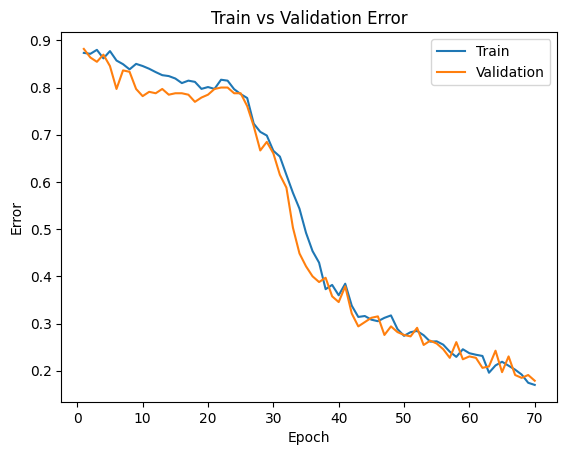

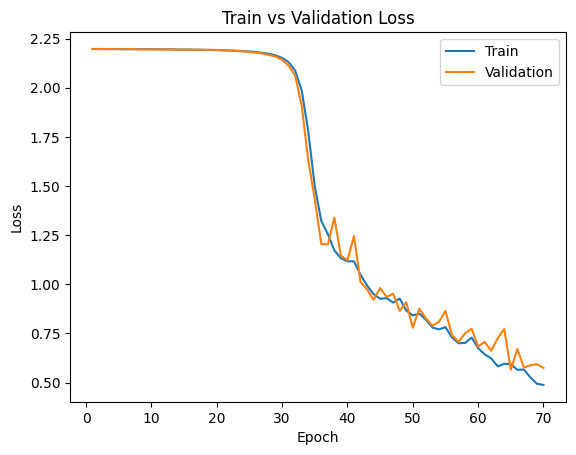

In [256]:
# plot the training curves for small_net
asl_net_model_path= get_model_name("asl_final", batch_size=64, learning_rate=0.0005, epoch=69)
plot_training_curve(asl_net_model_path)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

**I decided to choose the model from part 3biv, as both the training and validation curves are nicley fit. Also compared to all of the other models I tested, this one had the least signs of overfitting or underfitting as there is no increase from the validation loss curve and a few amount of big oscillations. This model uses an additional CNN layer as well as a smaller filter than the one from part (2). The model also uses a learning rate of 0.0005 as it ensures that the model parameters are updated in small steps, which helped prevent large oscillations. In order to find the learning rate that gave the best results I slowly decreased it until the model stopped overfitting a lot. The model using batch_size of 32 saw overfitting so I used batch_size of 64 instead which helped give a good balance of updates and also adding a small amount of unstability. Additionally, I tested with 25, 50, and 75 epochs so the model has enough iterations to learn the data more throughly and so that the training data loss would flatten out.**

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [25]:
# Load the model
num_classes = 9
net = ASLCNN_final(num_classes)
asl_net_model_path= get_model_name("asl_final", batch_size=64, learning_rate=0.0005, epoch=69)
state = torch.load(asl_net_model_path)
net.load_state_dict(state)
net.to(device)

ASLCNN_final(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)

In [26]:
# Load the data
train_loader, val_loader, test_loader, classes, train_indices, val_indices, test_indices = get_data_loader(data_dir, batch_size=64, image_size=(224, 224))

# Evaluate the model
criterion = nn.CrossEntropyLoss()
err, loss = evaluate(net, test_loader, criterion)
print("Test error: {}".format(err))
print("Test loss: {}".format(loss))

Test error: 0.21700879765395895
Test loss: 0.7413177490234375


In [27]:
print(f"Test accuracy: {(1 - err) * 100:.2f}%")

Test accuracy: 78.30%


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [30]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/home/jempio/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jempio/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [31]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...

data_dir = './Lab3_Gestures_Summer' 

# Load datasets
batch_size = 32
train_loader, val_loader, test_loader, classes, train_indices, val_indices, test_indices = get_data_loader(data_dir, batch_size)

alexnet.eval()

# Move the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

def compute_features(loader, model, device):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            features = model.features(imgs)
            features = features.view(features.size(0), -1)  # Flatten the features
            features = features.cpu().numpy()  
            features = torch.from_numpy(features)  
            features_list.append(features)
            labels_list.append(labels)
    features_tensor = torch.cat(features_list)
    labels_tensor = torch.cat(labels_list)
    return features_tensor, labels_tensor

In [32]:
# Sanity Check
# Create a dummy input
dummy_input = torch.ones((1, 3, 224, 224)).to(device)

with torch.no_grad():
    full_output = alexnet(dummy_input)
    feature_output = alexnet.features(dummy_input)

print("Full model output shape:", full_output.shape)
print("Feature extraction output shape:", feature_output.shape)

Full model output shape: torch.Size([1, 1000])
Feature extraction output shape: torch.Size([1, 256, 6, 6])


**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [33]:
# Extract and save features for each dataset
train_features, train_labels = compute_features(train_loader, alexnet, device)
torch.save((train_features, train_labels), 'train_features.pt')

val_features, val_labels = compute_features(val_loader, alexnet, device)
torch.save((val_features, val_labels), 'val_features.pt')

test_features, test_labels = compute_features(test_loader, alexnet, device)
torch.save((test_features, test_labels), 'test_features.pt')

In [34]:
def get_feature_loaders(batch_size):
    # Load features
    train_features, train_labels = torch.load('train_features.pt')
    val_features, val_labels = torch.load('val_features.pt')
    test_features, test_labels = torch.load('test_features.pt')

    # Create TensorDatasets and DataLoaders
    train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = torch.utils.data.TensorDataset(val_features, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [35]:
# My architecture consists of 2 fully connected layers.
# We don't need convolutional layers because the AlexNet feature extractor has already processed and extracted high-level features from the input images
# ReLU Activation is used for the first fully connected layer to introduce non-linearity and enable the model to learn complex patterns.
# Also I applied with a dropout rate of 0.5 after the first fully connected layer to prevent overfitting.
# The first fully connected layer uses 512 hidden units.

class AlexNetCNN(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCNN, self).__init__()
        self.name = "alexnet"
        # Assuming features are flattened from shape [N, 256, 6, 6] to [N, 256*6*6]
        self.fc1 = nn.Linear(256 * 6 * 6, 512)  # First fully connected layer
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, num_classes)  # Second fully connected layer

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input features
        x = F.relu(self.fc1(x))  # First fully connected layer with ReLU
        x = self.dropout(x)  # Dropout layer
        x = self.fc2(x)  # Second fully connected layer
        return x

In [36]:
num_classes = 9 
alexnet_model = AlexNetCNN(num_classes) 

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [37]:
def evaluate_alex_net(net, loader, criterion):
    net.eval()
    total_err = 0.0
    total_loss = 0.0
    total_epoch = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_epoch += labels.size(0)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / len(loader)
    return err, loss

def train_alex_net(net, batch_size=32, learning_rate=0.01, num_epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    net.to(device)  # Move model to GPU/CPU
    torch.manual_seed(1000)
    train_loader, val_loader, test_loader = get_feature_loaders(batch_size)
    
    criterion = nn.CrossEntropyLoss().to(device)  # Move criterion to GPU
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        net.train()  # Set the model to training mode
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_epoch += labels.size(0)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate_alex_net(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [38]:
num_classes = 9  # Replace with actual number of classes
alexnet_model = AlexNetCNN(num_classes)
train_alex_net(alexnet_model, batch_size=32, learning_rate=0.001, num_epochs=50)

Using device: cuda
Epoch 1: Train err: 0.46770025839793283, Train loss: 1.4203942819517485 |Validation err: 0.16666666666666666, Validation loss: 0.7439242547208612
Epoch 2: Train err: 0.19056847545219638, Train loss: 0.6146205706255776 |Validation err: 0.1393939393939394, Validation loss: 0.5165586417371576
Epoch 3: Train err: 0.12532299741602068, Train loss: 0.4057208962586461 |Validation err: 0.07878787878787878, Validation loss: 0.3684439537200061
Epoch 4: Train err: 0.09237726098191215, Train loss: 0.32348882452565797 |Validation err: 0.08181818181818182, Validation loss: 0.31489267267964105
Epoch 5: Train err: 0.0755813953488372, Train loss: 0.26378461323222335 |Validation err: 0.05757575757575758, Validation loss: 0.2901797511360862
Epoch 6: Train err: 0.05297157622739018, Train loss: 0.21051082303937602 |Validation err: 0.06060606060606061, Validation loss: 0.24334826659072528
Epoch 7: Train err: 0.04392764857881137, Train loss: 0.18423077829030096 |Validation err: 0.0545454545

In [39]:
# plot the training curves for small_net
def plot_training_curve_alex(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    n = len(train_err) # number of epochs

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title("Train Error")
    plt.plot(range(1, n+1), train_err, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title("Train Loss")
    plt.plot(range(1, n+1), train_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

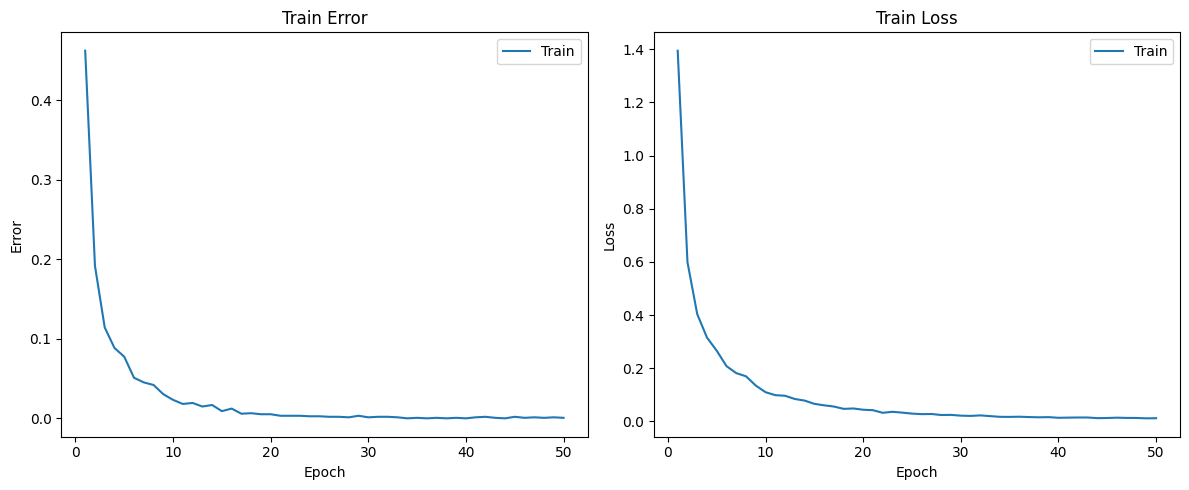

In [367]:
# plot the training curves for alex net
alexnet_model_path= get_model_name("alexnet", batch_size=32, learning_rate=0.001, epoch=49)
plot_training_curve_alex(alexnet_model_path)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [368]:
# Load the model
alexnet_model_path= get_model_name("alexnet", batch_size=32, learning_rate=0.001, epoch=49)
state = torch.load(alexnet_model_path)
net.load_state_dict(state)
net.to(device)

AlexNetCNN(
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)

In [374]:
# Evaluate the model
batch_size = 32
train_loader, val_loader, test_loader = get_feature_loaders(batch_size)
criterion = nn.CrossEntropyLoss().to(device)
alex_err, alex_loss = evaluate(net, test_loader, criterion)
print("Test error: {}".format(alex_err))
print("Test loss: {}".format(alex_loss))

Test error: 0.05865102639296188
Test loss: 0.20076469514010983


In [375]:
print(f"Test accuracy: {(1 - alex_err) * 100:.2f}%")
# 94.13% is better than the test accuracy I got in part 3(d) which was 78.30%

Test accuracy: 94.13%
